<a href="https://colab.research.google.com/github/karielson/PPGEP9002_INTELIGENCIA_COMPUTACIONAL/blob/main/DBSCAN_vs_K_means_Clustering_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Executar esta célula primeiro para instalar todas as bibliotecas necessárias
!pip install numpy pandas scikit-learn matplotlib seaborn

# Verificar as versões instaladas
import numpy as np
import pandas as pd
from sklearn import __version__ as sk_version
import matplotlib as mpl
import seaborn as sns

print("Versões das bibliotecas instaladas:")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Scikit-learn: {sk_version}")
print(f"Matplotlib: {mpl.__version__}")
print(f"Seaborn: {sns.__version__}")

Versões das bibliotecas instaladas:
NumPy: 1.26.4
Pandas: 2.2.2
Scikit-learn: 1.6.0
Matplotlib: 3.8.0
Seaborn: 0.13.2


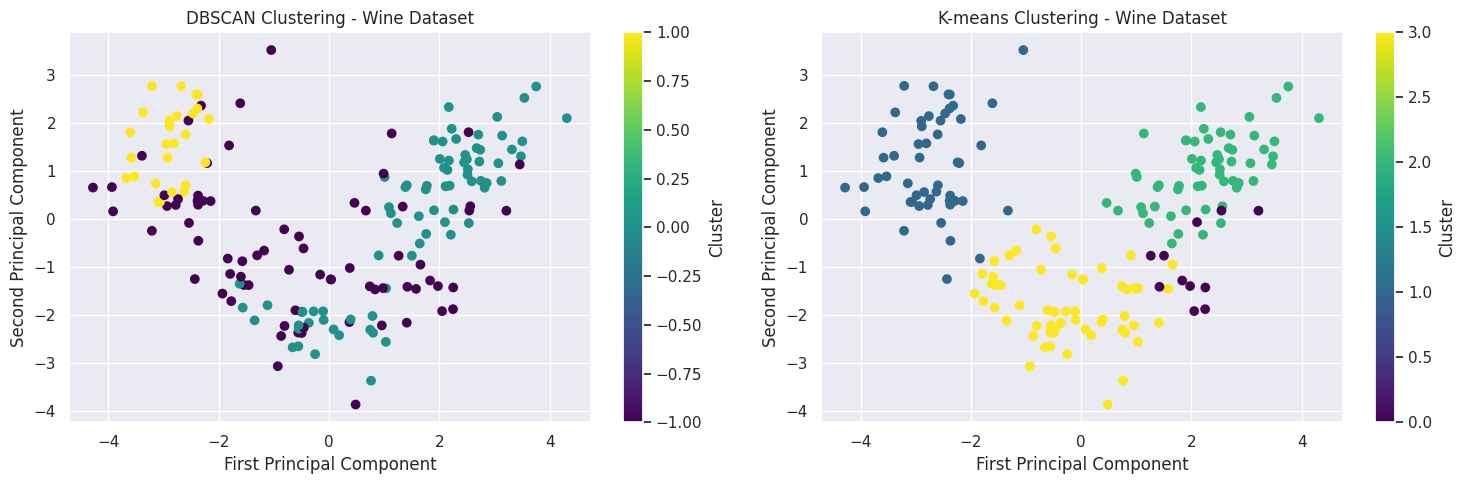

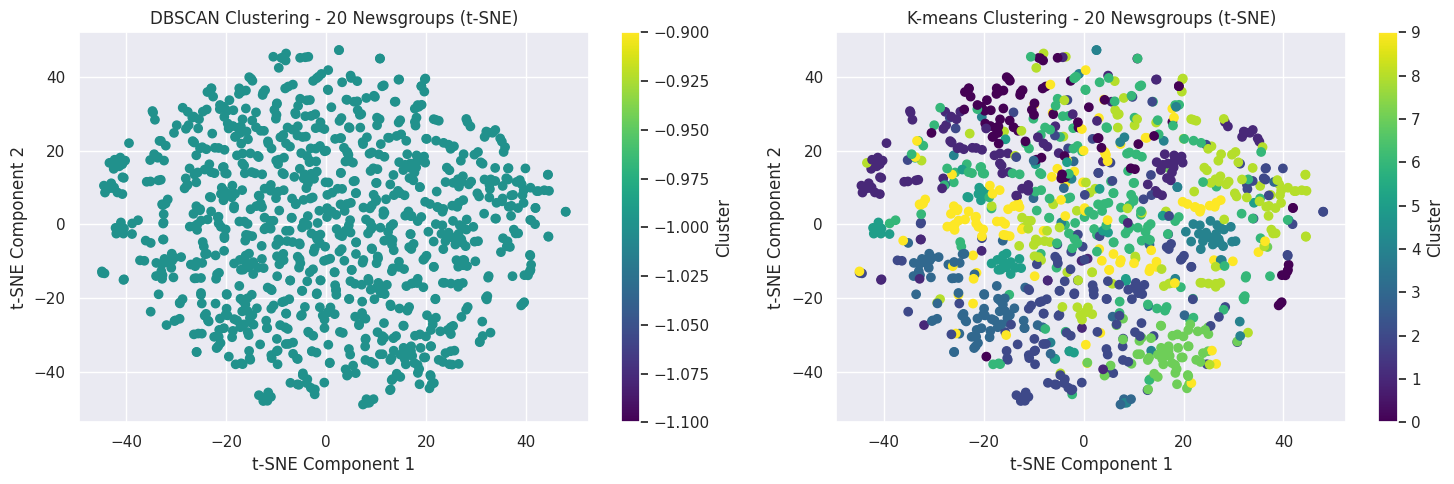

In [21]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine, fetch_20newsgroups
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração de estilo para os gráficos
plt.style.use('default')
sns.set_theme()

def find_optimal_eps(X, k=10):
    """
    Encontra um valor eps apropriado usando o método do cotovelo
    Args:
        X (array-like): Dados de entrada
        k (int): Número de vizinhos mais próximos a considerar
    Returns:
        float: Valor ideal de eps
    """
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]
    return np.percentile(distances, 90)

def analyze_wine_dataset():
    """
    Realiza a análise do dataset Wine utilizando DBSCAN e K-means,
    apresentando métricas e visualização dos clusters.
    """
    wine = load_wine()
    X = StandardScaler().fit_transform(wine.data)

    # Encontrar o valor ótimo de eps para DBSCAN
    eps_optimal = find_optimal_eps(X)
    dbscan = DBSCAN(eps=eps_optimal, min_samples=20)  # Aumentado min_samples para reduzir ruído
    dbscan_labels = dbscan.fit_predict(X)

    # Determinar o número ideal de clusters para K-means usando o método do cotovelo
    distortions = []
    K_range = range(1, 11)
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)

    optimal_k = 4  # Escolha manual baseada no método do cotovelo
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    kmeans_labels = kmeans.fit_predict(X)

    dbscan_n_clusters = len(np.unique(dbscan_labels[dbscan_labels >= 0]))
    dbscan_noise = np.sum(dbscan_labels == -1)
    kmeans_silhouette = silhouette_score(X, kmeans_labels)
    dbscan_silhouette = silhouette_score(X, dbscan_labels) if len(np.unique(dbscan_labels)) > 1 else 0

    pca = PCA(n_components=2)  # Reduz para 2 componentes principais para visualização
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis')
    plt.title('DBSCAN Clustering - Wine Dataset')
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')

    plt.subplot(1, 2, 2)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis')
    plt.title('K-means Clustering - Wine Dataset')
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')

    plt.tight_layout()
    plt.show()

    return {
        'dbscan_n_clusters': dbscan_n_clusters,
        'dbscan_noise': dbscan_noise,
        'kmeans_silhouette': kmeans_silhouette,
        'dbscan_silhouette': dbscan_silhouette
    }

def analyze_news_dataset():
    """
    Realiza a análise do dataset 20 Newsgroups utilizando DBSCAN e K-means,
    apresentando métricas e visualização dos clusters com t-SNE.
    """
    newsgroups = fetch_20newsgroups(subset='test', random_state=42)
    vectorizer = TfidfVectorizer(max_features=1500, stop_words='english', max_df=0.7, min_df=5)
    X = vectorizer.fit_transform(newsgroups.data[:1000])
    X_dense = X.toarray()

    # Ajuste do eps e min_samples para DBSCAN
    eps_optimal = 0.80
    dbscan = DBSCAN(eps=eps_optimal, min_samples=30, metric='manhattan')  # Usando distância Manhattan
    dbscan_labels = dbscan.fit_predict(X_dense)

    # Ajuste do número de clusters para K-means com validação
    kmeans = KMeans(n_clusters=10, random_state=42)  # Ajustado para 10 clusters
    kmeans_labels = kmeans.fit_predict(X_dense)

    dbscan_n_clusters = len(np.unique(dbscan_labels[dbscan_labels >= 0]))
    dbscan_noise = np.sum(dbscan_labels == -1)
    kmeans_silhouette = silhouette_score(X_dense, kmeans_labels)
    dbscan_silhouette = silhouette_score(X_dense, dbscan_labels) if len(np.unique(dbscan_labels)) > 1 else 0

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)  # Usando t-SNE para melhor visualização
    X_tsne = tsne.fit_transform(X_dense)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels, cmap='viridis')
    plt.title('DBSCAN Clustering - 20 Newsgroups (t-SNE)')
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')

    plt.subplot(1, 2, 2)
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='viridis')
    plt.title('K-means Clustering - 20 Newsgroups (t-SNE)')
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')

    plt.tight_layout()
    plt.show()

    return {
        'dbscan_n_clusters': dbscan_n_clusters,
        'dbscan_noise': dbscan_noise,
        'kmeans_silhouette': kmeans_silhouette,
        'dbscan_silhouette': dbscan_silhouette
    }

# Executar as análises
wine_results = analyze_wine_dataset()
news_results = analyze_news_dataset()

# Comparação final
comparison_df = pd.DataFrame([
    {'Dataset': 'Wine', **wine_results},
    {'Dataset': '20 Newsgroups', **news_results}
])



In [5]:
!apt

apt 2.4.13 (amd64)
Usage: apt [options] command

apt is a commandline package manager and provides commands for
searching and managing as well as querying information about packages.
It provides the same functionality as the specialized APT tools,
like apt-get and apt-cache, but enables options more suitable for
interactive use by default.

Most used commands:
  list - list packages based on package names
  search - search in package descriptions
  show - show package details
  install - install packages
  reinstall - reinstall packages
  remove - remove packages
  autoremove - Remove automatically all unused packages
  update - update list of available packages
  upgrade - upgrade the system by installing/upgrading packages
  full-upgrade - upgrade the system by removing/installing/upgrading packages
  edit-sources - edit the source information file
  satisfy - satisfy dependency strings

See apt(8) for more information about the available commands.
Configuration options and syntax is

In [4]:
!pip


Usage:   
  pip3 <command> [options]

Commands:
  install                     Install packages.
  download                    Download packages.
  uninstall                   Uninstall packages.
  freeze                      Output installed packages in requirements format.
  inspect                     Inspect the python environment.
  list                        List installed packages.
  show                        Show information about installed packages.
  check                       Verify installed packages have compatible dependencies.
  config                      Manage local and global configuration.
  search                      Search PyPI for packages.
  cache                       Inspect and manage pip's wheel cache.
  index                       Inspect information available from package indexes.
  wheel                       Build wheels from your requirements.
  hash                        Compute hashes of package archives.
  completion                  A helper c